In [368]:
import numpy as np
import matplotlib.pyplot as plt

### Sensor data

In [369]:
T = 1       # Time Sampling Interval
N = 100     # Number of samples
L = 500.0   # Sensor Position

# initial parameters
v = np.array([10.0, -2.0]) 
x0 = np.array([1000.0, 500.0])

# Sensor Positions
sensor1 = np.array([0.0, 0.0])
sensor2 = np.array([500.0, 0.0])

positions = np.zeros((N, 2))
for i in range(N):
    positions[i] = x0 + i * v * T

# Gaussian measurement noise
sigma_deg = 0.1 
sigma_rad = np.deg2rad(sigma_deg)
noise_factor = 1

# Get the sensor data for the positions
sensor_data = np.zeros((N, 2))
for i in range(N):
    delta1 = positions[i] - sensor1
    sensor_data[i][0] = np.arctan2(delta1[0], delta1[1]) + np.random.normal(0, sigma_rad) * noise_factor

    delta2 = positions[i] - sensor2
    sensor_data[i][1] = np.arctan2(delta2[0], delta2[1]) + np.random.normal(0, sigma_rad) * noise_factor



Plot the actual trajectory

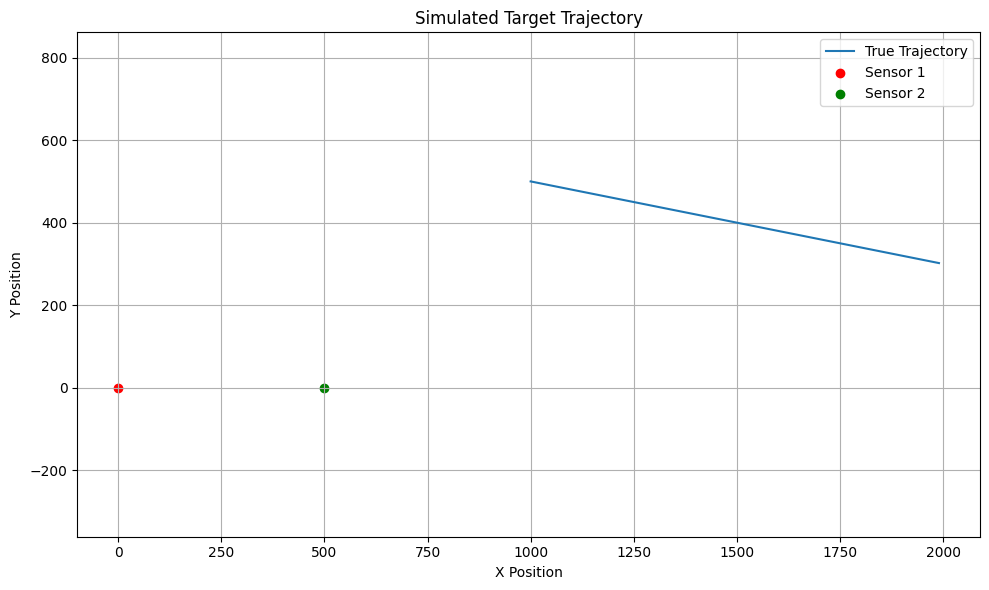

In [370]:
plt.figure(figsize=(10, 6))
plt.plot(positions[:, 0], positions[:, 1], label="True Trajectory")
plt.scatter(sensor1[0], sensor1[1], color='red', label="Sensor 1")
plt.scatter(sensor2[0], sensor2[1], color='green', label="Sensor 2")
plt.title("Simulated Target Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Cubature Kalman Filter Implementation

State Function

In [371]:
def f(x, dt=1.0):
    return np.array(
        [
            x[0] + x[2] * dt,
            x[1] + x[3] * dt,
            x[2],
            x[3],
        ]
    )

Measurement Function

In [372]:
def h(x):
    delta1 = x[:2] - sensor1
    delta2 = x[:2] - sensor2

    return np.array(
        [
            np.arctan2(delta1[0], delta1[1]), 
            np.arctan2(delta2[0], delta2[1])
        ]
    )

Getting the cubature points

In [373]:
def get_cubature_points(x, n, P):
    S = np.linalg.cholesky(P)
    Xi = np.sqrt(n) * np.hstack((S, -S)) + x[:, None]
    return Xi

Prediction Step in the CKF

In [374]:
def ckf_prediction(x, P, Q, dt=1.0):
    n = x.size
    W = 1 / (2 * n)
    Xi = get_cubature_points(x, n, P)
    x_pred = np.zeros(4)

    for i in range(2 * n):
        val = f(Xi[:, i], dt) * W
        x_pred += val
    
    P_pred = Q.copy()
    for i in range(2 * n):
        dx = f(Xi[:, i], dt) - x_pred
        P_pred += np.outer(dx, dx) * W
    
    return x_pred, P_pred


Correction step in the CKF

In [375]:
def ckf_correction(x_pred, P_pred, y, R, dt=1):
    n = x_pred.size
    m = y.size
    W = 1 / (2 * n)
    Xi = get_cubature_points(x_pred, n, P_pred)

    y_pred = np.zeros(2)
    for i in range(2 * n):
        val = h(Xi[:, i]) * W
        y_pred += val
    
    Pxy = np.zeros((n, m))
    for i in range(2 * n):
        dx = Xi[:, i] - x_pred
        dy = h(Xi[:, i]) - y_pred
        Pxy += np.outer(dx, dy) * W

    Sk = R.copy()
    for i in range(2 * n):
        dx = h(Xi[:, i]) - y_pred
        Sk += np.outer(dx, dx) * W
    
    Kf = Pxy @ np.linalg.inv(Sk)
    x_upd = x_pred + Kf @ (y - y_pred)
    P_upd = P_pred - Kf @ (Pxy.T)
    return x_upd, P_upd

Run the CKF and calculate the error between the true value and CKF output

In [376]:
n = 4  # Size of the state
m = 2  # Size of the measurement
x_est = np.hstack((x0, v))  # Initial point
# Initial parameters
P_est = np.eye(n) * 100
Q = np.eye(n) * 0.1
R = np.eye(m) * (sigma_rad ** 2)

errors = []
x_estimates = []

# Loop through the CKF, feed more data and check difference between output and true value
for i in range(1, N):
    yi = sensor_data[i]
    x_act = np.hstack((positions[i], v))
    x_pred, P_pred = ckf_prediction(x_est, P_est, Q)
    x_est, P_est = ckf_correction(x_pred, P_pred, yi, R)
    x_estimates.append(x_est)
    errors.append(np.linalg.norm(x_est - x_act))
    

Plot the errors

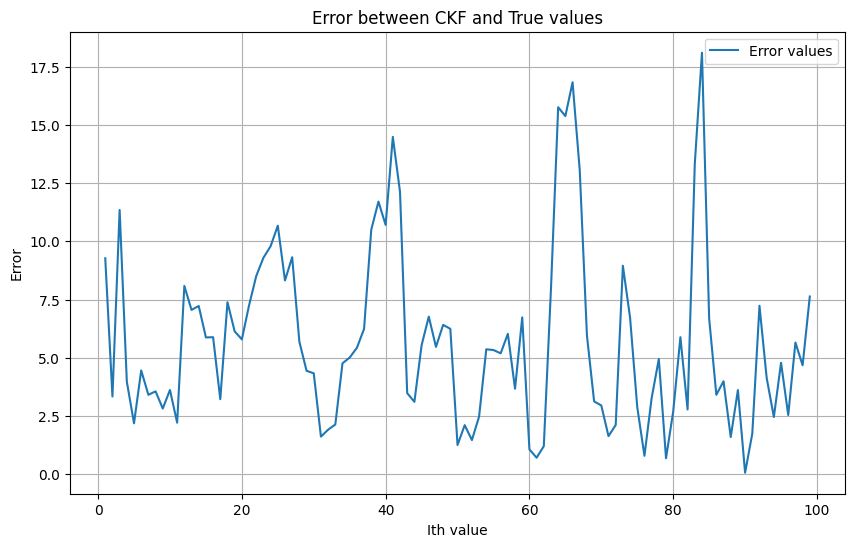

In [377]:
i_values = range(1, N)
plt.figure(figsize=(10, 6))
plt.plot(i_values, errors, label="Error values")
plt.title("Error between CKF and True values")
plt.xlabel("Ith value")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.show()


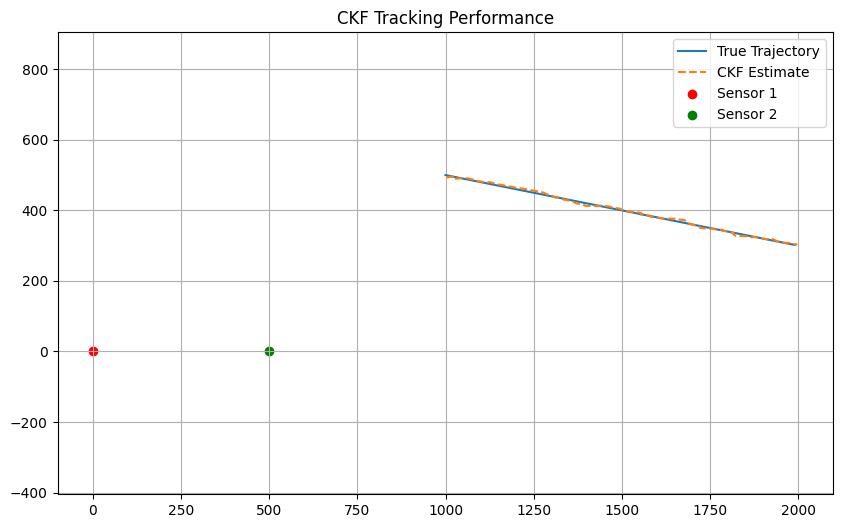

In [378]:
estimates = np.array(x_estimates)

plt.figure(figsize=(10, 6))
plt.plot(positions[:, 0], positions[:, 1], label="True Trajectory")
plt.plot(estimates[:, 0], estimates[:, 1], label="CKF Estimate", linestyle='--')

plt.scatter(sensor1[0], sensor1[1], color='red', label="Sensor 1")
plt.scatter(sensor2[0], sensor2[1], color='green', label="Sensor 2")
plt.title("CKF Tracking Performance")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()